# Install the libraries

In [1]:
!pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 110.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 112.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


# Import the prepared data

In [2]:
from datasets import load_from_disk

In [3]:
path = '/content/drive/MyDrive/tokenized_emotion_data'
tokenized_emotion = load_from_disk(path)

In [4]:
tokenized_emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

# Training a Text Classifier

In [5]:
from transformers import AutoModel, AutoTokenizer
import torch

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = "distilbert-base-uncased"
model = AutoModel.from_pretrained(checkpoint).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

### Test

In [8]:
test_txt = "Hi, I'm Ayad. I'm from Egypt and I love NLP."
inputs = tokenizer(test_txt, return_tensors='pt')
inputs

{'input_ids': tensor([[  101,  7632,  1010,  1045,  1005,  1049,  1037, 25152,  1012,  1045,
          1005,  1049,  2013,  5279,  1998,  1045,  2293, 17953,  2361,  1012,
           102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [9]:
inputs['input_ids'].size()

torch.Size([1, 21])

In [10]:
inputs = {k:v.to(device) for k, v in inputs.items()}
inputs

{'input_ids': tensor([[  101,  7632,  1010,  1045,  1005,  1049,  1037, 25152,  1012,  1045,
           1005,  1049,  2013,  5279,  1998,  1045,  2293, 17953,  2361,  1012,
            102]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
        device='cuda:0')}

In [11]:
with torch.no_grad():
  outputs = model(**inputs)

In [12]:
outputs.last_hidden_state.shape

torch.Size([1, 21, 768])

In [13]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

### Apply it on the whole dataset

In [14]:
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    outputs = model(**inputs)
  return {'hidden_states':outputs.last_hidden_state[:,0].cpu().numpy()}

The `map()` method requires the processing function to return Python or NumPy objects when we’re using batched inputs.

In [15]:
tokenized_emotion.set_format('torch', columns=['label', 'input_ids', 'attention_mask'])

In [16]:
emotion_hidden_states = tokenized_emotion.map(extract_hidden_states, batched=True)

In [17]:
emotion_hidden_states['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_states']

### Creating a feature matrix

In [18]:
import numpy as np

X_train = emotion_hidden_states['train']['hidden_states']
X_val = emotion_hidden_states['validation']['hidden_states']

y_train = emotion_hidden_states['train']['label']
y_val = emotion_hidden_states['validation']['label']

In [19]:
print(f'X_train Shape : {X_train.shape}')
print(f'X_val Shape : {X_val.shape}')

X_train Shape : torch.Size([16000, 768])
X_val Shape : torch.Size([2000, 768])


## Training a simple classifier

In [20]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1234)

In [21]:
lr_model.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1234)

In [22]:
lr_model.score(X_val, y_val)

0.6345

We can examine whether our model is any good by comparing it
against a simple baseline. In Scikit-learn there is a DummyClassifier that can be used
to build a classifier with simple heuristics such as always choosing the majority class
or always drawing a random class. In this case the best-performing heuristic is to
always choose the most frequent class, which yields an accuracy of about 35%:

In [23]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="most_frequent")

In [24]:
dummy_classifier.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [25]:
dummy_classifier.score(X_val, y_val)

0.352

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_cm(predicted_y, actual_y, labels):
  cm = confusion_matrix(actual_y, predicted_y, normalize='true')
  fig, ax = plt.subplots(figsize=(9, 9))
  disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=labels)
  disp.plot(cmap='Blues', ax=ax, colorbar=False, values_format='.2f')
  plt.title('Confusion Matrix')
  plt.show()

In [27]:
y_pred = lr_model.predict(X_val)

In [28]:
labels = emotion_hidden_states['train'].features['label'].names
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

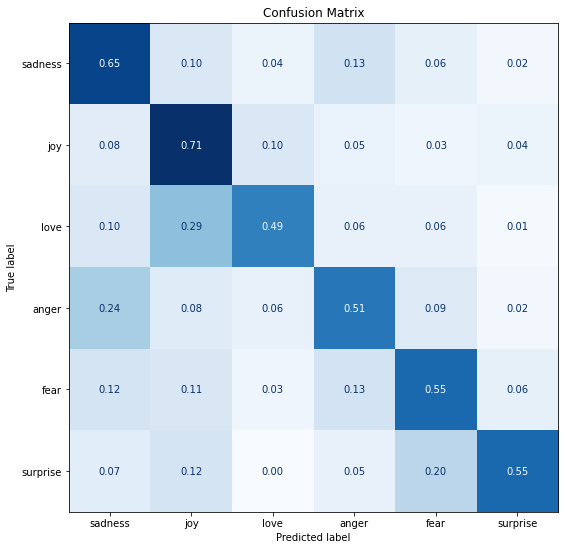

In [29]:
plot_cm(y_val, y_pred, labels)

## Fine-Tuning Transformers

In [30]:
checkpoint

'distilbert-base-uncased'

In [31]:
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [32]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=len(labels))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

We use the `AutoModelForSequenceClassification` model instead of AutoModel. The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the
pretrained model outputs, which can be easily trained with the base model.

### Defining the performance metrics

In [33]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

### Training the model

In [34]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [35]:
from transformers import Trainer, TrainingArguments

batch_size = 64
dir = f'/content/drive/MyDrive/tokenized_emotion_data/model{checkpoint}_finetuned_on_emotion_data'

args = TrainingArguments(
    output_dir=dir,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 4,
    weight_decay=0.01,
    evaluation_strategy = 'epoch', # Evaluation is done at the end of each epoch
    disable_tqdm = False,
    logging_steps = len(tokenized_emotion['train'])//batch_size,
    push_to_hub = True
)

In [37]:
trainer = Trainer(
    model=model, args=args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_emotion['train'],
    eval_dataset=tokenized_emotion['validation'],
    tokenizer=tokenizer
)

/content/drive/MyDrive/tokenized_emotion_data/modeldistilbert-base-uncased_finetuned_on_emotion_data is already a clone of https://huggingface.co/ayad33/modeldistilbert-base-uncased_finetuned_on_emotion_data. Make sure you pull the latest changes with `repo.git_pull()`.


In [38]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 16000
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1000
  Number of trainable parameters = 66958086
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster 

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.517300,0.197232,0.929000,0.928197
2,0.143600,0.136101,0.937000,0.936948
3,0.093500,0.133426,0.939500,0.939730
4,0.068700,0.136376,0.936000,0.935959


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/tokenized_emotion_data/modeldistilbert-base-uncased_finetuned_on_emotion_data/checkpoint-500
Configuration saved in /content/drive/MyDrive/tokenized_emotion_data/modeldistilbert-base-uncased_finetuned_on_emotion_data/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/tokenized_emotion_data/modeldistilbert-base-uncased_finetuned_on_emotion_data/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/tokenized_emotion_data/modeldistilbert-base-uncased_finetuned_on_emotion_data/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/d

TrainOutput(global_step=1000, training_loss=0.20575633239746094, metrics={'train_runtime': 545.8438, 'train_samples_per_second': 117.25, 'train_steps_per_second': 1.832, 'total_flos': 1438003067217408.0, 'train_loss': 0.20575633239746094, 'epoch': 4.0})

In [39]:
pred_output = trainer.predict(tokenized_emotion['validation'])

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 64


In [40]:
pred_output.predictions.shape

(2000, 6)

In [41]:
pred_output.label_ids.shape

(2000,)

In [42]:
pred_output.metrics

{'test_loss': 0.1363755762577057,
 'test_accuracy': 0.936,
 'test_f1': 0.9359593054213129,
 'test_runtime': 4.2022,
 'test_samples_per_second': 475.936,
 'test_steps_per_second': 7.615}

In [43]:
pred_output.predictions[:2]

array([[ 7.2112713 , -1.9278961 , -1.8133783 , -1.0105177 , -1.3763722 ,
        -2.5094137 ],
       [ 7.264323  , -1.8066691 , -2.210239  , -0.70172924, -1.315794  ,
        -2.5312352 ]], dtype=float32)

In [44]:
y_pred = np.argmax(pred_output.predictions, axis=1)

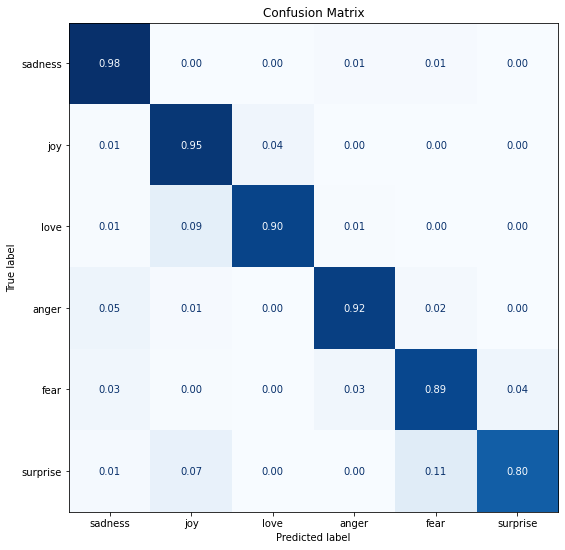

In [45]:
plot_cm(y_pred, y_val, labels)

# Error analysis

In [46]:
tokenized_emotion.set_format('torch', columns=['label', 'input_ids', 'attention_mask'])

In [47]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):

  inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")

  return {"loss": loss.cpu().numpy(),
          "predicted_label": pred_label.cpu().numpy()}

In [48]:
tokenized_emotion["validation"] = tokenized_emotion["validation"].map(forward_pass_with_label, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [49]:
int2str = lambda num: tokenized_emotion["train"].features["label"].names[num]

In [50]:
tokenized_emotion.set_format("pandas")

cols = ["text", "label", "predicted_label", "loss"]

df_test = tokenized_emotion["validation"][:][cols]
df_test["label"] = df_test["label"].apply(int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(int2str))

In [51]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1500,i guess we would naturally feel a sense of lon...,anger,sadness,7.928195
1963,i called myself pro life and voted for perry w...,joy,sadness,6.882781
405,i have been feeling extraordinarily indecisive...,fear,joy,6.120808
415,im kind of embarrassed about feeling that way ...,love,sadness,5.756200
882,i feel badly about reneging on my commitment t...,love,joy,5.279655
1919,i should admit when consuming alcohol myself i...,fear,sadness,5.271913
1836,i got a very nasty electrical shock when i was...,fear,anger,5.250685
1870,i guess i feel betrayed because i admired him ...,joy,love,5.217936
1950,i as representative of everything thats wrong ...,surprise,sadness,5.074947
259,when i noticed two spiders running on the floo...,anger,fear,4.755035


In [52]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1208,i feel brave again tubing were even going to t...,joy,joy,0.000655
968,i have that feeling most days of the week im s...,joy,joy,0.000670
1437,i am feeling brave i will attempt it,joy,joy,0.000673
1782,im only trying to tell you exactly how i feel ...,joy,joy,0.000674
742,i do have some pictures in my head of stuff i ...,joy,joy,0.000675
934,i feel a positive responsibility to see this t...,joy,joy,0.000681
1669,i feel like i come from a pretty innocent happ...,joy,joy,0.000690
1458,i feel that people often offer compliments not...,joy,joy,0.000691
1269,i feel charming i feel whimsy,joy,joy,0.000694
1263,i feel this way about blake lively,joy,joy,0.000695


# Saving and sharing the model

In [ ]:
# trainer.push_to_hub(commit_message=f"{checkpoint} model finetuning on emotion_dataset completed!")

Saving model checkpoint to /content/drive/MyDrive/tokenized_emotion_data/modeldistilbert-base-uncased_finetuned_on_emotion_data
Configuration saved in /content/drive/MyDrive/tokenized_emotion_data/modeldistilbert-base-uncased_finetuned_on_emotion_data/config.json
Model weights saved in /content/drive/MyDrive/tokenized_emotion_data/modeldistilbert-base-uncased_finetuned_on_emotion_data/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/tokenized_emotion_data/modeldistilbert-base-uncased_finetuned_on_emotion_data/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/tokenized_emotion_data/modeldistilbert-base-uncased_finetuned_on_emotion_data/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


In [ ]:
from transformers import pipeline
import pandas as pd
import seaborn as sns

model_id = "ayad33/modeldistilbert-base-uncased_finetuned_on_emotion_data"
classifier = pipeline("text-classification", model=model_id)

In [ ]:
custom_tweet = "I saw a movie today and it was really good."
pred = classifier(custom_tweet, return_all_scores=True)
pred

In [ ]:
pred_df = pd.DataFrame(pred[0])
pred_df

In [ ]:
plt.bar(labels, 100 * pred_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()